In [1]:
# some imports we will need later
from urllib.request import urlopen
import hashlib
import IPython.display as jupyter
import pydantic
import h5py
# --------------------------------

## Using MetadorContainer to manage Metadata in HDF5 files

This tutorial is intended for people who already have a basic idea of what Metador is and the value it can provide. Probably now you simply want to jump right in and get started as quickly as possible. These lessons will guide you through the main features and interfaces of the Metador framework step by step and will explain how to perform common tasks which are needed to implement a new use-case or connect a scientific domain to the Metador ecosystem.

**Learning Goals:**

* Understand the main features provided by the `MetadorContainer` interface
* Learn to use basic metadata schemas in order to attach metadata objects to data in a container
* Learn to discover and access metadata stored in a possibly unknown container

### Introduction

Making very domain-specific and heterogeneaus research datasets more [FAIR](https://en.wikipedia.org/wiki/FAIR_data) is hard. The goal of the Metador platform is to support standardization efforts of domain-specific research data and metadata and make reaping the benefits of these efforts as easy as possible.

As in most domains high-volume scientific data is numerical, Metador containers are built on top of the well-established and mature [HDF5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), which is optimized for this kind of data.
Thus, **Metador is essentially built around HDF5 archives of research data where metadata is organized in a certain way**, so that various components of the Metador framework are able to make sense of your data and provide features based on that information. Luckily, you don't need to know most of the technical details to create valid Metador containers with rich metadata - you just have to think about your metadata needs, Metador will do the bookkeeping behind the scenes.

In fact, if you have used the `h5py` library in Python to archive your data, then you already know almost everything you need to know to create Metador containers. If you have never used `h5py`, please [familiarize yourself with h5py](https://docs.h5py.org/en/latest/quick.html#quick) and come back later, when you have a working understanding of `h5py.File`, `h5py.Group`, `h5py.Dataset` and how to use them to store and access data in HDF5 files.

Now, assuming that you are familiar with `h5py`, you can think of a Metador container as a special `h5py.File`. Only instead of storing simple key-value pairs as "metadata" using `.attrs`, you are enabled to add rich, complex, structured metadata through a new property of `Dataset`s and `Group`s, which is called `.meta`. Note that you still *can* use `.attrs`, if you need to, but the Metador framework will completely ignore them. When you work with Metador containers, it is best to consider `.attrs` as a legacy feature that is to be avoided.

<div class="alert alert-block alert-info">
    <b>NOTE:</b> As metadata can be attached to both <tt>Group</tt>s and <tt>Dataset</tt>s, for the sake of brevity we refer to both of these simply as <tt>Node</tt>s of the container.
</div>

### Creating or Opening a Container

To work with Metador containers, you simply can use `MetadorContainer` instead of `h5py.File` whenever you create or open an HDF file.

On the first sight, you will notice that a `MetadorContainer` seems to behave like a normal `h5py.File`:

In [2]:
from metador_core.container import MetadorContainer

# store the name of our container (we'll keep working with it)
CONTAINER_NAME: str = "my_first_container.h5"

# access a container by immediately wrapping the freshly created h5py.File
with MetadorContainer(CONTAINER_NAME, "w") as mc:
    # store something
    mc["group/list"] = [9, 8, 7, 42]
    # list contents of container
    print("Contents:")
    mc.visit(print)
    print("---")

    # access the new dataset
    my_list = mc["group/list"]
    print(my_list)

    # index into it
    print("The answer is:", my_list[3])

Contents:
group
group/list
---
<HDF5 dataset "list": shape (4,), type "<i8">
The answer is: 42


The Metador container we created *is* an HDF5 file - technically, you *can* open it just as any other regular HDF5 file, or even inspect it with `hdfview`. But you might be surprised to find many objects you did not (knowingly) create - these are the "technical details" which `MetadorContainer` hides from you for your own good. Doing changes outside of the provided `MetadorContainer` interface **will** disturb these additional structures, so just do not do it.

<div class="alert alert-block alert-danger">
    <b>IMPORTANT:</b> <b>Never</b> open the container as <tt>h5py.File</tt> directly! 
    <b>Always</b> use your Metador containers with <tt>MetadorContainer</tt>, or you risk ending up with broken containers!
</div>

Also, to give some more general advice to save you from trouble down the line - just as with any kind of resource, you should use the special `with` notation to ensure that the file is properly closed when you are done with it or some exception happens. If you do not use `with`, you are responsible for calling `close()` yourself, and most likely will run into annoying issues that waste your valuable time.

<div class="alert alert-block alert-warning">
    <b>IMPORTANT:</b> Whenever possible, <b>use <tt>with</tt> when accessing containers</b> and avoid using the same container object in multiple Jupyter cells!
 </div>

### Baby's First Metadata: Plugins and Schemas

In contrast to other systems that allow you to attach arbitrary key-value pairs as "metadata" and call that "being generic", Metador provides a generic metadata system that still prioritizes **standards, structure and correctness**.
Therefore, all metadata must we valid according to some known **metadata schema**.
These schemas are used for automatic validation, i.e. checking that the metadata has the right shape, data types and seems plausible. You simply cannot attach invalid metadata to container nodes.
The requirement to have schemas for all metadata is undeniably additional work, but *it is work that pays off - we promise!*

As with any kind of standard, **the value of a schema is proportional to the number of its users**.
In order to minimize the required extra work and at the same time maximize its value, 
Metador is designed as an extensible and open framework that encourages the sharing and reuse of various elements, including schemas.  For very general kinds of data, Metador provides metadata schemas that can and should be used or extended. For your domain-specific needs, you will first need to understand your metadata, and then formalize this understanding by using, extending or creating a metadata schema **plugin** (this will be the topic of a different lesson). In this lesson, we will only use the default schemas that are always available to you.

#### Accessing Metador Plugin Groups and Plugins

All installed plugins, including all schemas that you can use in your current Python environment, can be accessed through the Metador plugin system living in `metador_core.plugins`. You can list all different kinds of plugins that are available like this:

In [3]:
from metador_core.plugins import plugingroups
print(plugingroups)

Available 'plugingroup' plugins:
	'harvester' (0.1.0)
	'packer' (0.1.0)
	'schema' (0.1.0)
	'widget' (0.1.0)
	'plugingroup' (0.1.0)


All the individual plugin groups can be imported individually, e.g. to get quick access to schemas, you can simply import and list them like this:

In [4]:
from metador_core.plugins import schemas
print(schemas)

Available 'schema' plugins:
	'core.bib' (0.1.0)
	'core.dashboard' (0.1.0)
	'core.dir' (0.1.0)
	'core.file' (0.1.0)
	'core.imagefile' (0.1.0)
	'core.org' (0.1.0)
	'core.packerinfo' (0.1.0)
	'core.person' (0.1.0)
	'core.table' (0.1.0)
	'example.matsci.info' (0.1.0)
	'example.matsci.instrument' (0.1.0)
	'example.matsci.material' (0.1.0)
	'example.matsci.method' (0.1.0)
	'example.matsci.specimen' (0.1.0)


#### Accessing Available Metadata Schemas

A proper scientific dataset should, at the very least, provide some bibliographic metadata - after all, you want to be credited for it, and should credit the shoulders you are standing on.
Often, such metadata is requested during the submission into a public repository and is stored "outside"
of the published data. Metador is a **dataset-centric** system that encourages the creation of archives which are **self-describing and self-contained**. Metadata explaining the contents should be stored alongside the data
and be readily available to anyone who gets a hold of a copy of the container, even if the repository is not available anymore 50 years from now.

First we need to load the default schema plugin for bibliographic metadata. If you simply want to get any version, you can access the group like a dict:

In [5]:
# following line roughly corresponds to the pseudo-Python statement:
#     from schemas import 'core.bib' as BibMeta
BibMeta = schemas["core.bib"]

# we can show some plugin info, including the version:
print(BibMeta.Plugin)

{
  "group": "schema",
  "name": "core.bib",
  "version": "0.1.0"
}


If you know what version you need and expect, you should access it using `get` and pass an expected version. Then Metador will also check whether the installed version is compatible:

In [6]:
BibMeta = schemas.get("core.bib", (0, 0, 1)) # ok

try: # this will fail
    SpecificBibMetaVersion = schemas.get("core.bib", (2,3,4))
except KeyError as e:
    print(e)

#### Creating a metadata object by instantiating a schema
Now let's use the schema we loaded to add some bibliographic information to our container!

In [7]:
try:
    # create bibliographic metadata object
    my_bibmeta = BibMeta(name="Title for my container")  # <- this will fail
    
except pydantic.ValidationError as e:
    print(e)  # see what went wrong

3 validation errors for BibMeta
abstract
  field required (type=value_error.missing)
author
  field required (type=value_error.missing)
dateCreated
  field required (type=value_error.missing)


You can see that the schema complains, because we did not provide all the required information. Let us try again:

In [8]:
from datetime import datetime
today = datetime.today().isoformat()

container_author = {
    "@id": "https://orcid.org/0000-0002-1825-0097",
    "givenName": "Josiah", "familyName": "Carberry"
}

my_bibmeta = BibMeta(
    name="Title for my container",
    abstract="This is my first Metador-compliant container",
    author=[container_author],
    creator=container_author,
    dateCreated=today
)
print(my_bibmeta)  # look at what we have created

{
  "name": "Title for my container",
  "@context": "https://w3id.org/ro/crate/1.1/context",
  "@type": "Dataset",
  "abstract": "This is my first Metador-compliant container",
  "author": [
    {
      "@id": "https://orcid.org/0000-0002-1825-0097",
      "name": "Josiah Carberry",
      "@context": "https://w3id.org/ro/crate/1.1/context",
      "@type": "Person",
      "givenName": "Josiah",
      "familyName": "Carberry"
    }
  ],
  "dateCreated": "2023-09-06T12:47:43.119041",
  "hasPart": [],
  "creator": {
    "@id": "https://orcid.org/0000-0002-1825-0097",
    "givenName": "Josiah",
    "familyName": "Carberry"
  }
}


Metador strives to be compliant with existing metadata standards and provide *semantic* metadata that is backed by existing vocabularies and ontologies, so the generic schemas are aligned with [RO-Crate](https://www.researchobject.org/ro-crate/1.1/). The schema class will  try to understand (i.e., *parse*) your metadata and bring it into standard-compliant form. This is the reason why now you can see more fields that you actually provided - the output is, in fact, valid [**JSON-LD**](https://en.wikipedia.org/wiki/JSON-LD)!

We provided the `author` information in a plain old Python `dict`. This is okay - schemas will try to understand your input, if provided in basic JSON-compatible types (i.e. `int`, `float`, `bool`, `list` and `dict`). Nevertheless, it is recommended that you construct more complex metadata objects using the corresponding schema class to profit from validation early on. Otherwise, in the worst case, you will only see problems with your metadata when you try attaching it to a node.

<div class="alert alert-block alert-info">
    <b>NOTE:</b> Prefer using schema classes over plain dicts when constructing metadata.
</div>

#### Exploring and Inspecting a Schema

But how can you know what kind of data a schema wants you to provide? What if the schema is complicated and nested? How do you know what schemas or classes you need? To answer all these questions, each schema can be inspected through the special `Fields` attribute:

In [9]:
BibMeta.Fields

author
	type: List[Person]
	origin: metador_core.schema.common.BibMeta (plugin: core.bib 0.1.0)
	schemas: Person
	description:
		List of authors (creators of the actual data).
	
name
	type: <class 'metador_core.schema.types.NonEmptyStr'>
	origin: metador_core.schema.common.BibMeta (plugin: core.bib 0.1.0)
	description:
		Name, title or caption of the entity.
	
abstract
	type: <class 'metador_core.schema.types.NonEmptyStr'>
	origin: metador_core.schema.common.BibMeta (plugin: core.bib 0.1.0)
	description:
		A short description that summarizes the creative work.
	
dateCreated
	type: typing.Union[datetime.date, datetime.datetime]
	origin: metador_core.schema.common.BibMeta (plugin: core.bib 0.1.0)
	
id_
	type: Annotated[Optional[NonEmptyStr], Field(alias='@id')]
	origin: metador_core.schema.ld.LDSchema
	
identifier
	type: Optional[Union[URL, Text]]
	origin: metador_core.schema.common.schemaorg.Thing
	description:
		Arbitrary identifier of the entity.
		
		Prefer @id if the identifier is w

As you can see, the `Fields` interface provides useful information about every field in a schema:

* The **type**, which tells you what kind of objects are suitable
* The **origin**, telling you in which schema the field was defined
* If provided, a **description** of the field (contents of the docstring)
* The **schemas** that you can use to construct an object of a suitable type

The last point is especially important - not all schemas are registered as plugins, for various reasons: they can be too general, too specific, not meaningful on their own, etc., but be a part of some schema you want or need to use. Through `Fields` you can access *all* schemas that are relevant, even if they are not a plugin.

<div class="alert alert-block alert-danger">
    <b>IMPORTANT:</b> <b>Never</b> import schema classes directly, <b>always</b> go through <tt>metador_core.plugins.schemas</tt> for installed plugin schemas, and use the <tt>Fields</tt> interface to access nested schemas that are needed for fields. That way, if schemas are relocated for whatever reason, your code will still work!
</div>

Now let us improve the schema instance construction. Let us first figure out what we can put into the `author` field:

In [10]:
print(BibMeta.Fields.author)

author
	type: List[Person]
	origin: metador_core.schema.common.BibMeta (plugin: core.bib 0.1.0)
	schemas: Person
	description:
		List of authors (creators of the actual data).
	


Now we know that for both fields we need something called `Person`. Let's now get our hands on that `Person` class and see what it wants:

In [11]:
Person = BibMeta.Fields.author.schemas.Person

print(Person.Fields)

id_
	type: Annotated[Optional[NonEmptyStr], Field(alias='@id')]
	origin: metador_core.schema.ld.LDSchema
	
name
	type: Optional[Text]
	origin: metador_core.schema.common.schemaorg.Thing
	description:
		Name, title or caption of the entity.
	
identifier
	type: Optional[Union[URL, Text]]
	origin: metador_core.schema.common.schemaorg.Thing
	description:
		Arbitrary identifier of the entity.
		
		Prefer @id if the identifier is web-resolvable, or use more
		specific fields if available.
	
url
	type: Optional[URL]
	origin: metador_core.schema.common.schemaorg.Thing
	description:
		URL of the entity.
	
description
	type: Optional[Text]
	origin: metador_core.schema.common.schemaorg.Thing
	description:
		Description of the entity.
	
alternateName
	type: Optional[List[Text]]
	origin: metador_core.schema.common.schemaorg.Thing
	description:
		Known aliases of the entity.
	
sameAs
	type: Optional[List[URL]]
	origin: metador_core.schema.common.schemaorg.Thing
	
givenName
	type: Optional[Text]
	ori

Now we have all information to recreate our bibliographic metadata using the correct `Person` schema:

In [12]:
container_author = Person(
    id_ = "https://orcid.org/0000-0002-1825-0097",
    givenName= "Josiah", familyName="Carberry"
)

my_bibmeta = BibMeta(
    name="Title for my container",
    abstract="This is my first Metador-compliant container",
    author=[container_author],
    dateCreated=today,
)
print(my_bibmeta.json(indent=2))  # look at what we have created

{
  "name": "Title for my container",
  "@context": "https://w3id.org/ro/crate/1.1/context",
  "@type": "Dataset",
  "abstract": "This is my first Metador-compliant container",
  "author": [
    {
      "@id": "https://orcid.org/0000-0002-1825-0097",
      "name": "Josiah Carberry",
      "@context": "https://w3id.org/ro/crate/1.1/context",
      "@type": "Person",
      "givenName": "Josiah",
      "familyName": "Carberry"
    }
  ],
  "dateCreated": "2023-09-06T12:47:43.119041",
  "hasPart": []
}


After this brief detour about schema access and introspection, let us (finally!) add the bibliographic metadata object we created to the container:

In [13]:
with MetadorContainer(CONTAINER_NAME, "a") as mc:
    print("Attached metadata before:", mc["/"].meta.keys())  # <- empty set

    mc["/"].meta["core.bib"] = my_bibmeta  # set the metadata

    print("Attached metadata after:", mc["/"].meta.keys())  # <- includes "core.bib" now
    
    # retrieve the metadata again and sanity-check:
    retrieved = mc["/"].meta["core.bib"]
    print(retrieved.dict())
    print("Got back what we put in:", my_bibmeta == retrieved)
    print("Got back a BibMeta object:", isinstance(retrieved, BibMeta))

Attached metadata before: dict_keys([])
Attached metadata after: dict_keys(['core.bib'])
{'name': 'Title for my container', '@context': 'https://w3id.org/ro/crate/1.1/context', '@type': 'Dataset', 'abstract': 'This is my first Metador-compliant container', 'author': [{'@id': AnyHttpUrl('https://orcid.org/0000-0002-1825-0097', ), 'name': 'Josiah Carberry', '@context': 'https://w3id.org/ro/crate/1.1/context', '@type': 'Person', 'givenName': 'Josiah', 'familyName': 'Carberry'}], 'dateCreated': datetime.datetime(2023, 9, 6, 12, 47, 43, 119041), 'hasPart': set()}
Got back what we put in: True
Got back a BibMeta object: True


<div class="alert alert-block alert-info">
    <b>NOTE:</b> All general metadata about the whole container and its contents should be attached directly to the container root group (i.e., path <tt>"/"</tt>).
</div>

### We Need More Data: Embedding Files in a MetadorContainer

Even though Metador is based on HDF5, you might still want to (and in fact should!) store **all** files that are relevant for your dataset inside the container, even if the file contents are not a multidimensional numerical table. A `MetadorContainer` thus can also be seen as a more powerful substitute for simply archiving your project directory into a ZIP file and should contain everything that is helpful to other researchers to understand and work with your data.

<div class="alert alert-block alert-info">
    <b>High-level Guideline for Container Creation:</b>
    <ul><li>
    Embed metadata in a container using the <tt>.meta</tt> interface and Metador schemas whenever possible
    </li><li>
    Store numerical data as <tt>numpy.ndarray</tt>s (i.e. as usual with <tt>h5py</tt>)
    and add suitable metadata, e.g. using the <tt>core.table</tt> schema
    </li><li>
    Embed any other data (or metadata where no Metador schemas exist yet) as raw bytes
    and add metadata compatible with the <tt>core.file</tt> schema
    </li></ul>
</div>

We will now demonstrate how to embed files for a very common use-case - images. Images can be scientific data themselves, be a visualization of scientific data or simply provide a thumbnail, so it is very likely that you will want to include some in your container.

#### Getting an Image File

In practice, you will probably have some images stored on your computer that you would like to embed.
For demonstration purposes, we will simply grab an image file from the internet and prepare all the information that we will need. As an exercise, feel free to adapt the following code for one of your images.

python-logo.png sha256: a92254c92269252313148acd7c3a8d595fa6cc8921ec28b2ee0f5c75f84297c3


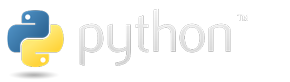

In [14]:
# download an image from the internet:
IMG_NAME = "python-logo.png"
img_file: bytes = urlopen(f"https://www.python.org/static/img/{IMG_NAME}").read()

# we will need these values to construct the metadata:
img_w, img_h = 290, 82  # <- size in pixels
img_mime = "image/png"  # <- MIME type
img_sha256 = hashlib.sha256(img_file).hexdigest()  # <- sha256 hashsum

# look at our image:
print(IMG_NAME, "sha256:", img_sha256)
jupyter.display(jupyter.Image(data=img_file))

#### Constructing the Metadata

Now we are ready to construct the metadata object for the image gathering all the pieces of information:

In [15]:
# get the default basic metadata schema for image files
ImageFileMeta = schemas["core.imagefile"]

# prepare the metadata
img_meta = ImageFileMeta(
    filename=IMG_NAME,  # preserve the original filename (we'll rename it in the container)
    
    # following is required for all files:
    contentSize=len(img_file),
    encodingFormat=img_mime,
    sha256=img_sha256,

    # following is required for all images:
    width=img_w,
    height=img_h,
    )

print(img_meta.yaml())  # look at what the schema made out of it

'@context': https://w3id.org/ro/crate/1.1/context
'@type': File
contentSize: 10102
encodingFormat: image/png
filename: python-logo.png
height:
  '@context': https://schema.org
  '@type': QuantitativeValue
  unitText: px
  value: 82
sha256: a92254c92269252313148acd7c3a8d595fa6cc8921ec28b2ee0f5c75f84297c3
width:
  '@context': https://schema.org
  '@type': QuantitativeValue
  unitText: px
  value: 290



#### Interlude: Some Notes on Metadata Serialization and Parsing

By now, you have seen all three ways of serializing a metadata object:

* `.dict()`, returns a plain Python `dict` containing the metadata
* `.json()`, returns a string with a valid JSON encoding of the metadata
* `.yaml()`, returns a string with a valid YAML encoding of the metadata

When you `print` a metadata object, you will see a pretty-printed `json` serialization.

You never have to use the serialization functions explicitly when interfacing with a `MetadorContainer`, but they are helpful for inspecting or extracting metadata stored in a container, i.e. to print it (as we do here) or save a copy of the metadata in a separate file.
These are not Metador-specific features, but are provided by the [pydantic](https://pydantic-docs.helpmanual.io/usage/models/) library which is the foundation for all Metador schemas. Once you need to write your own schemas, you might want to familiarize yourself with this library.

Furthermore, observe what happened to the simple `width` and `height` values that we provided when constructing the metadata object:

* the values were parsed into objects representing schema.org-compliant `QuantitativeValue`
* the values were enriched with the information that they denote pixels (`px`)

Such inference is possible in situations when there is a unique correct unit expected by the used schema for some attribute, as we have in this case. This demonstrates how **Metador tries to simplify creation of rich metadata** whenever it can infer some piece of knowledge encoded in the used schema.

Now see what happens if we try to assign a value with a wrong unit:

In [16]:
try:
    img_meta.width = "42 meters"
except pydantic.ValidationError as e:
    print(e)

2 validation errors for ImageFileMeta
width -> __root__ -> 0
  value is not a valid integer (type=type_error.integer)
width -> __root__ -> 0
  value is not a valid float (type=type_error.float)


This demonstrates how **Metador tries to help the user avoiding mistakes** whenever it can detect them, to ensure that containers have metadata which is as correct and as complete as possible.
After this little interlude, let us proceed and finally put the image file and its prepared metadata into our container:

In [17]:
import numpy as np

# put image into the container
with MetadorContainer(CONTAINER_NAME, "a") as mc:
    # embed image in the container
    #
    # NOTE: raw bytes embedded into HDF5 must be wrapped in np.void, see:
    # https://docs.h5py.org/en/latest/strings.html#how-to-store-raw-binary-data
    mc["/images/some_image"] = np.void(img_file) 
    
    # attach image file metadata
    mc["/images/some_image"].meta["core.imagefile"] = img_meta

<div class="alert alert-block alert-info">
    <b>NOTE:</b> You might wonder now: is creating metadata always so cumbersome? No, you will usually not construct metadata for each file like this, we only did this for didactic purposes in order to demonstrate the validation and normalization capabilities built into schemas. <b>You usually will use a harvester pipeline to assemble metadata</b>, and might want to write harvesters for new file types yourself. <b>Harvesters will be introduced in a later tutorial</b>.
</div>


### Finding Metadata: Schema Inheritance and the Table of Contents

By now, you have seen that you can attach metadata to groups and datasets very much like with the HDF5-native `.attrs`, only that the `.meta` interface is based on schema plugins that provide additional valuable features for complex scientific metadata needs, such as validation and semantic enrichment. In this section, we will look at the remaining features that `MetadorContainer` provides.

#### Schema Inheritance

As **Metador encourages reuse**, it supports **schema inheritance**, i.e. subtyping. A schema plugin can be a specialization of a different, more general schema that we call the **parent schema**. Conversely, each object stored for a more specialized schema can be interpreted as an object of the parent schema, ignoring "extra stuff" that make the child schema for specific.

In the previous section, we recommended to attach to each embedded file an object compatible with the `core.file` schema, while in the example we embedded an image attaching metadata based on the `core.imagefile` schema. This works because the `core.imagefile` schema is a specialization, i.e. a child schema based on `core.file`. Let us now understand what exactly this entails:

In [18]:
FileMeta = schemas.get("core.file", (0,1,0))

with MetadorContainer(CONTAINER_NAME, "r") as mc:
    img = mc["/images/some_image"]  # get node of the embedded image
    
    # list attached metadata
    print(list(img.meta.keys()))  # only lists the schemas as-added!
    
    print("Has core.imagefile metadata:", "core.imagefile" in img.meta)  # as expected
    image_meta = img.meta["core.imagefile"]
        
    print("Has core.file metadata:", "core.file" in img.meta)  # surprise!
    file_meta = img.meta["core.file"]  # any idea what happens now?
    
    # Let's figure it out:
    print("Type of image_meta:", repr(type(image_meta)))
    print("Type of file_meta:", repr(type(file_meta)))
    print("file_meta is an instance of ImageFileMeta:", isinstance(file_meta, ImageFileMeta))
    print("image_meta is an instance of FileMeta:", isinstance(image_meta, FileMeta))

['core.imagefile']
Has core.imagefile metadata: True
Has core.file metadata: True
Type of image_meta: <class 'metador_core.schema.common.ImageFileMeta'> (core.imagefile 0.1.0)
Type of file_meta: <class 'metador_core.schema.common.rocrate.FileMeta'> (core.file 0.1.0)
file_meta is an instance of ImageFileMeta: False
image_meta is an instance of FileMeta: True


If you are familiar with class inheritance in object-oriented programming, the outputs are not surprising, as this is exactly what is happening here. We will not go into technical details about Metador schema inheritance, but give a brief example why this is a very useful feature to have in the context of schemas.

Imagine that you work with a very niche image file format `.niche` and want to embed such a file in a container. As a progressively thinking scientist who cares about FAIRness of their data, you want to re-use existing schemas and standards. Therefore, you design the schema `niche-imagefile` for your niche format as a specialization of the `core.imagefile` (the one we used above), with some extra properties about the niche encoding of your image data that you want to store alongside the image.

Unfortunately, other researchers who might get a copy of your container will not have your `niche-imagefile` schema available. Luckily, they do have the schemas `core.file` and `core.imagefile`. As both schemas are "ancestor" schemas of your schema, the researchers still can access general information about your image, such as `width` and `height`, by requesting `core.imagefile` metadata. If they care about specifics of your image, they might later consider installing your schema plugin to access all of the information.

But how do they even know that your `.niche` file, in fact, is a well-described image file at all?

#### Table of Contents

The container **table of contents** to the rescue! Its main feature is the ability to query available metadata in the container. When exploring an unknown container, we might not even know what we want to look at yet. The TOC can list all schemas that are available in the container, to give you an idea what you can query for:

In [19]:
with MetadorContainer(CONTAINER_NAME, "r") as mc:
    
    print("Schemas available in the container and Python package+version providing it:")
    
    for schema in mc.metador.schemas:
        # The provider package is the one that was used when creating the container,
        # so in general it might be different from the one you have installed!
        pkg = mc.metador.schemas.provider(schema)
        print(schema.name, schema.version,  ":", pkg.name, pkg.version)

Schemas available in the container and Python package+version providing it:
core.bib (0, 1, 0) : metador-core (0, 1, 1)
core.imagefile (0, 1, 0) : metador-core (0, 1, 1)


Our container has actual metadata objects of types `"core.bib"` and `"core.imagefile"`.
By now, you can probably guess that the other two listed schemas are respective parent schemas.
So even if we did not know anything about this container before, now we know that we e.g. can ask for files:

In [20]:
with MetadorContainer(CONTAINER_NAME, "r") as mc:
    
    # query all nodes in the container for "core.file"-compatible metadata
    for node in mc.metador.query("core.file"):
        metadata = node.meta.get("core.file")
        # print the path of the embedded file and its hashsum
        # (core.file has hashsum as mandatory attribute - all files must have it!)
        print(node.name, ":", metadata.sha256) 

/images/some_image : a92254c92269252313148acd7c3a8d595fa6cc8921ec28b2ee0f5c75f84297c3


So we have successfully created a container, added basic bibilographic metadata to it, embedded an image file and also attached some metadata about it to help other people finding it. This concludes our first lesson giving you a first taste of Metador. We hope that you enjoyed it and we will see you again in the next lesson!

### TL;DR: Summary

#### Opening and Closing Containers

* Metador containers are essentially "special" HDF5 files
* Use the Python `with` syntax to avoid technical problems
* Wrap your `h5py.File` objects with `MetadorContainer` and use only the wrapped object

#### Attaching and Accessing Metadata

* Do not use `.attrs` for storing metadata, unless you have specific reasons (e.g. compliance to another standard)
* Do use `.meta` (provided by `MetadorContainer`) to attach metadata to container nodes
* Metador metadata is always validated against a metadata schema
* Usable metadata schemas (special Python classes) are provided by the Metador plugin system
* Metadata is stored and retrieved through objects that are instances of these schemas
* You can retrieve a more metadata object as any of its parent schemas (schema inheritance)

#### Inspecting Metadata Schemas

* Use `.Fields` on a schema that you use to get information about expected types and nested schemas
* Through `SomeSchema.Fields.fieldX.schemas` you can access nested schemas that might not be exposed as separate plugins
* Always use this mechanism instead of trying to `import` these inner schemas

#### Using Metadata Standards

* The default metadata schemas are designed for compliance with **schema.org** and **ROCrate**
* All additional plugin schemas should also strive to reuse existing schemas and semantic standards
* For general metadata, try to follow RO-Crate recommentations (e.g. that researchers should be referenced by their ORCID)
* General metadata about the whole container should be attached to the container root group

#### Searching for Metadata

* The container table of contents is accessible with `.metador` and can be used to find interesting (meta)data
* Use `.metador.schemas` to see all available metadata types in the container
* Use `.metador.query(...)` to iterate through all nodes that have a certain kind of metadata
* The `.metador.query(...)` operation also supports schema inheritance